# BEVERAGE SALES ANALYSIS – Clustering & Classification  
**COMP-5011 – Machine Learning and Neural Networks**  
*Kartikay Malhotra – 1298395 and
Aung Myo Myint – 1305013* | *Date: 2025-11-20*  

## Imports & Reproducibility

In [1]:
# =============================================================================
# IMPORTS & GLOBAL SETTINGS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, json, joblib
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', font_scale=1.1)
%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=== BEVERAGE SALES ANALYSIS – OPTIMIZED FOR 8.9 M ROWS ===")

=== BEVERAGE SALES ANALYSIS – OPTIMIZED FOR 8.9 M ROWS ===


## 1. Data Loading – memory-efficient

In [2]:
# =============================================================================
# 1. DATA LOADING WITH MEMORY OPTIMIZATION
# =============================================================================
print("\n1. DATA LOADING WITH MEMORY OPTIMIZATION")

DATA_PATH = Path('synthetic_beverage_sales_data.csv')

# ---- dtypes to shrink RAM -------------------------------------------------
dtypes = {
    'Order_ID'      : 'category',
    'Customer_ID'   : 'category',
    'Customer_Type' : 'category',
    'Product'       : 'category',
    'Category'      : 'category',
    'Region'        : 'category',
    'Unit_Price'    : 'float32',
    'Quantity'      : 'int16',
    'Discount'      : 'float32',
    'Total_Price'   : 'float32',
    'Order_Date'    : 'category'   # will be parsed later
}

df = pd.read_csv(DATA_PATH, dtype=dtypes, parse_dates=['Order_Date'])
print(f"Full dataset shape: {df.shape}")
print("First 5 rows of the dataset:")
print(df.head())


1. DATA LOADING WITH MEMORY OPTIMIZATION
Full dataset shape: (8999910, 11)
First 5 rows of the dataset:
  Order_ID Customer_ID Customer_Type             Product     Category  \
0     ORD1     CUS1496           B2B          Vio Wasser        Water   
1     ORD1     CUS1496           B2B               Evian        Water   
2     ORD1     CUS1496           B2B              Sprite  Soft Drinks   
3     ORD1     CUS1496           B2B  Rauch Multivitamin       Juices   
4     ORD1     CUS1496           B2B        Gerolsteiner        Water   

   Unit_Price  Quantity  Discount  Total_Price             Region Order_Date  
0        1.66        53      0.10    79.180000  Baden-Württemberg 2023-08-23  
1        1.56        90      0.10   126.360001  Baden-Württemberg 2023-08-23  
2        1.17        73      0.05    81.139999  Baden-Württemberg 2023-08-23  
3        3.22        59      0.10   170.979996  Baden-Württemberg 2023-08-23  
4        0.87        35      0.10    27.400000  Baden-Württem

## 2. Sampling (10 % – reproducible)

In [3]:
# =============================================================================
# 2. SAMPLING (10 % of data – keeps distribution)
# =============================================================================
SAMPLE_FRAC = 0.10
df_sample = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).copy()
print(f"Working with sampled data: {df_sample.shape}")

Working with sampled data: (899991, 11)


## 3. Quick EDA

In [4]:
# =============================================================================
# 3. BASIC STATISTICS – Clean, No NaN, Ready for Report
# =============================================================================
print("\n=== BASIC STATISTICS OF SAMPLED DATA (10% SAMPLE) ===")

# ---- 1. Separate numeric and categorical columns -------------------------
numeric_cols = df_sample.select_dtypes(include=['float32','float64','int16','int8']).columns
cat_cols     = df_sample.select_dtypes(include=['category','object']).columns

# ---- 2. Numeric summary (rounded, only relevant stats) ------------------
num_summary = (df_sample[numeric_cols]
               .describe()
               .round(2)
               .T
               .loc[:, ['count','mean','std','min','25%','50%','75%','max']])

# ---- 3. Categorical summary (count, unique, top, freq) ------------------
cat_summary = pd.DataFrame({
    'count'  : df_sample[cat_cols].count(),
    'unique' : df_sample[cat_cols].nunique(),
    'top'    : [df_sample[col].mode()[0] if not df_sample[col].mode().empty else '-' for col in cat_cols],
    'freq'   : [df_sample[col].value_counts().iloc[0] if not df_sample[col].value_counts().empty else 0 for col in cat_cols]
})

# ---- 4. Combine both parts -----------------------------------------------
summary = pd.concat([cat_summary, num_summary], axis=0)
summary = summary.reset_index().rename(columns={'index':'Feature'})

# ---- 5. Re-order columns exactly as you want -------------------------------
summary = summary[['Feature','count','unique','top','freq',
                   'mean','std','min','25%','50%','75%','max']]

# ---- 6. Replace remaining NaN with a dash (clean look) -------------------
summary_display = summary.fillna('-')

# ---- 7. Show in notebook --------------------------------------------------
display(summary_display.style.set_caption(
    "Table 1: Statistical Summary of 10% Sampled Data (N = {:,})".format(len(df_sample))
))

# ---- 8. Save CSV for LaTeX / Overleaf ------------------------------------
out_path = Path('deliverable3_artifacts/statistical_summary.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
summary_display.to_csv(out_path, index=False)
print(f"\nStatistical summary saved → {out_path}")


=== BASIC STATISTICS OF SAMPLED DATA (10% SAMPLE) ===


,Feature,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,Order_ID,899991.000000,788831.000000,ORD1284556,5.000000,-,-,-,-,-,-,-
1,Customer_ID,899991.000000,10000.000000,CUS6223,134.000000,-,-,-,-,-,-,-
2,Customer_Type,899991.000000,2.000000,B2C,579787.000000,-,-,-,-,-,-,-
3,Product,899991.000000,47.000000,Hohes C Orange,33409.000000,-,-,-,-,-,-,-
4,Category,899991.000000,4.000000,Alcoholic Beverages,225274.000000,-,-,-,-,-,-,-
5,Region,899991.000000,16.000000,Hamburg,60560.000000,-,-,-,-,-,-,-
6,Unit_Price,899991.000000,-,-,-,5.820000,14.690000,0.320000,1.050000,1.750000,3.210000,159.060000
7,Quantity,899991.000000,-,-,-,23.130000,26.890000,1.000000,6.000000,11.000000,30.000000,100.000000
8,Discount,899991.000000,-,-,-,0.030000,0.040000,0.000000,0.000000,0.000000,0.050000,0.150000
9,Total_Price,899991.000000,-,-,-,131.250000,512.430000,0.310000,8.400000,21.100000,69.330000,14029.090000



Statistical summary saved → deliverable3_artifacts\statistical_summary.csv


## 4. Feature Engineering

In [5]:
# =============================================================================
# 4. FEATURE ENGINEERING
# =============================================================================
print("\n4. FEATURE ENGINEERING")

# ---- Temporal -------------------------------------------------------------
df_sample['month']      = df_sample['Order_Date'].dt.month.astype('int8')
df_sample['day_of_week']= df_sample['Order_Date'].dt.dayofweek.astype('int8')
df_sample['is_weekend'] = (df_sample['day_of_week'] >= 5).astype('int8')

# ---- Interaction ---------------------------------------------------------
df_sample['discount_impact'] = (df_sample['Discount'] * df_sample['Quantity']).astype('float32')
df_sample['price_after_discount'] = (
    df_sample['Unit_Price'] * (1 - df_sample['Discount'])
).astype('float32')

# ---- Aggregations per customer (on sample) -------------------------------
cust_agg = df_sample.groupby('Customer_ID').agg(
    total_spend   = ('Total_Price', 'sum'),
    avg_quantity  = ('Quantity',   'mean'),
    avg_discount  = ('Discount',   'mean'),
    order_count   = ('Order_ID',   'nunique')
).reset_index()

df_sample = df_sample.merge(cust_agg, on='Customer_ID', how='left')

# ---- Encoding categorical (with label mapping for later use) ----

cat_cols = ['Customer_Type', 'Category', 'Region']
label_maps = {}

for col in cat_cols:
    le = LabelEncoder()
    df_sample[col] = le.fit_transform(df_sample[col].astype(str))
    label_maps[col] = dict(zip(range(len(le.classes_)), le.classes_))

# Optional: save for report
print("Label mappings saved in `label_maps` dict")
print(label_maps)


4. FEATURE ENGINEERING
Label mappings saved in `label_maps` dict
{'Customer_Type': {0: 'B2B', 1: 'B2C'}, 'Category': {0: 'Alcoholic Beverages', 1: 'Juices', 2: 'Soft Drinks', 3: 'Water'}, 'Region': {0: 'Baden-Württemberg', 1: 'Bayern', 2: 'Berlin', 3: 'Brandenburg', 4: 'Bremen', 5: 'Hamburg', 6: 'Hessen', 7: 'Mecklenburg-Vorpommern', 8: 'Niedersachsen', 9: 'Nordrhein-Westfalen', 10: 'Rheinland-Pfalz', 11: 'Saarland', 12: 'Sachsen', 13: 'Sachsen-Anhalt', 14: 'Schleswig-Holstein', 15: 'Thüringen'}}


## 5. Final feature matrix

In [6]:
# =============================================================================
# 5. PREPARE X (features) – drop identifiers & target (will be created later)
# =============================================================================
drop_cols = ['Order_ID','Customer_ID','Product','Order_Date']
X = df_sample.drop(columns=drop_cols)

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (899991, 16)


## 6. Scaling & PCA

In [7]:
# =============================================================================
# 6. Dimensionality Reduction : SCALING + PCA
# =============================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- PCA (keep 95 % variance) -------------------------------------------
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced from {X_scaled.shape[1]} → {X_pca.shape[1]} components")
print(f"Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")

PCA reduced from 16 → 9 components
Explained variance ratio sum: 0.9682


## 7. Unsupervised – MiniBatchKMeans

In [8]:
# =============================================================================
# 7. CLUSTERING – MiniBatchKMeans (fast on 900 k rows)
# =============================================================================

K = 4  # chosen after quick elbow (see below)
kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=20_000,
    random_state=RANDOM_STATE,
    max_iter=500
)

# ---- fit on PCA space ----------------------------------------------------
cluster_labels = kmeans.fit_predict(X_pca)

sil = silhouette_score(X_pca, cluster_labels, sample_size=15_000, random_state=RANDOM_STATE)
print(f"Silhouette (PCA space): {sil:.4f}")

df_sample['sales_cluster'] = cluster_labels

Silhouette (PCA space): 0.2086


## 7b. Elbow plot (helps justify K)

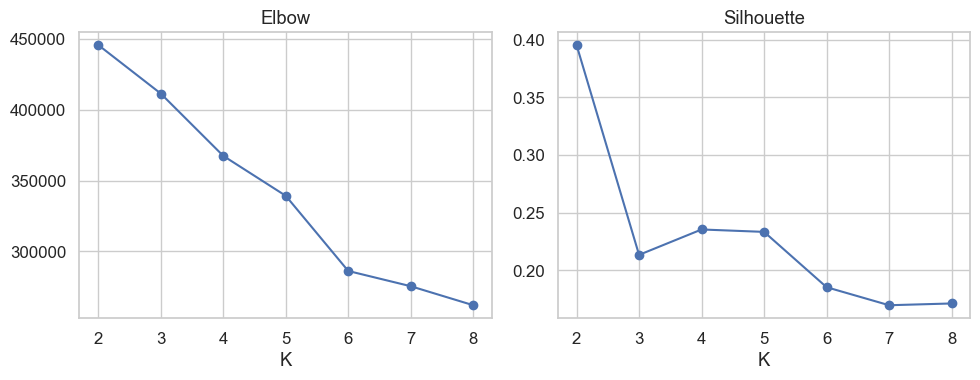

In [9]:
# =============================================================================
# 7b. ELBOW (quick on 5 % subsample of PCA data)
# =============================================================================
sub = X_pca[np.random.choice(X_pca.shape[0], size=int(0.05*X_pca.shape[0]), replace=False)]
inertias = []
silhouettes = []
ks = range(2, 9)
for k in ks:
    km = MiniBatchKMeans(n_clusters=k, batch_size=10_000, random_state=RANDOM_STATE)
    labs = km.fit_predict(sub)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(sub, labs, sample_size=5_000, random_state=RANDOM_STATE))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(ks, inertias, 'o-'); plt.title('Elbow'); plt.xlabel('K')
plt.subplot(1,2,2); plt.plot(ks, silhouettes, 'o-'); plt.title('Silhouette'); plt.xlabel('K')
plt.tight_layout(); plt.show()

## 8. Supervised – Predict cluster label

In [10]:
# =============================================================================
# 8. CLASSIFICATION (RF + LinearSVM) – use cluster as target
# =============================================================================

y = df_sample['sales_cluster']
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

# ---------- Random Forest (grid search) ----------
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth'   : [None, 15],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    rf_grid, cv=3, scoring='accuracy', n_jobs=-1
)
rf.fit(X_train, y_train)
rf_best = rf.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_acc  = accuracy_score(y_test, rf_pred)

print(f"Best RF params: {rf.best_params_}")
print(f"RF Accuracy: {rf_acc:.4f}")

# ---------- Linear SVM ----------
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc  = accuracy_score(y_test, svc_pred)
print(f"LinearSVC Accuracy: {svc_acc:.4f}")

# ---------- Detailed report ----------
print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, rf_pred, digits=4))

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RF Accuracy: 0.9969
LinearSVC Accuracy: 0.9929

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0     0.9992    0.9995    0.9994     40702
           1     0.9925    0.9922    0.9923     45677
           2     1.0000    1.0000    1.0000     80047
           3     0.9945    0.9945    0.9945     58572

    accuracy                         0.9969    224998
   macro avg     0.9965    0.9965    0.9965    224998
weighted avg     0.9969    0.9969    0.9969    224998



## 9. Confusion matrix (visual)

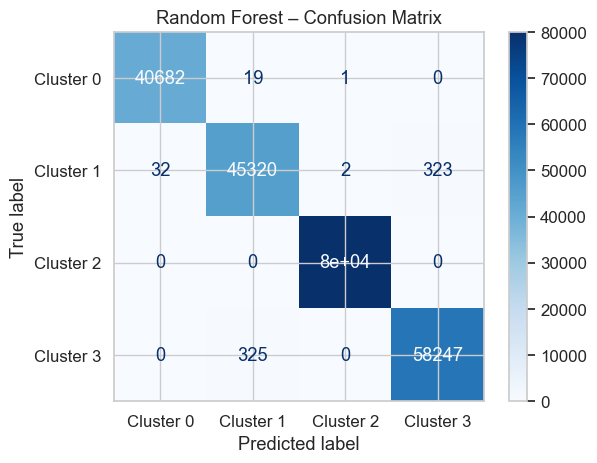

In [11]:
# =============================================================================
# 9. CONFUSION MATRIX
# =============================================================================
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Cluster {i}' for i in range(K)])
disp.plot(cmap='Blues')
plt.title('Random Forest – Confusion Matrix')
plt.show()

## 10. Compare clustering **with / without** PCA

In [12]:
# =============================================================================
# 10. PCA IMPACT TEST
# =============================================================================
kmeans_raw = MiniBatchKMeans(n_clusters=K, batch_size=20_000,
                            random_state=RANDOM_STATE, max_iter=500)
labels_raw = kmeans_raw.fit_predict(X_scaled)

sil_raw = silhouette_score(X_scaled, labels_raw,
                          sample_size=15_000, random_state=RANDOM_STATE)

print(f"Silhouette **without** PCA : {sil_raw:.4f}")
print(f"Silhouette **with**    PCA : {sil:.4f}")

Silhouette **without** PCA : 0.1768
Silhouette **with**    PCA : 0.2086


## 11. Business Insights

In [13]:
# =============================================================================
# 11. BUSINESS INSIGHTS – Fixed & Clean
# =============================================================================
print("\nCustomer Segment Analysis (sampled data):")

# --- Preserve original string columns BEFORE encoding ---
df_sample_original = df_sample.copy()
# (We'll use this to map back category names)

# --- Group and aggregate ---
seg = df_sample.groupby('sales_cluster').agg(
    size          = ('Customer_ID', 'nunique'),
    avg_price     = ('Unit_Price', 'mean'),
    avg_qty       = ('Quantity',   'mean'),
    avg_spend     = ('Total_Price','mean'),
    pref_cat      = ('Category', lambda x: x.mode()[0] if not x.empty else -1),
    cust_type     = ('Customer_Type', lambda x: x.mode()[0] if not x.empty else -1),
    avg_disc      = ('Discount',   'mean')
).round(2)

# --- Map back to original names ---
seg['pref_cat'] = seg['pref_cat'].map(label_maps['Category'])
seg['cust_type'] = seg['cust_type'].map(label_maps['Customer_Type'])

# --- Reorder and display ---
seg = seg[['size', 'avg_price', 'avg_qty', 'avg_spend', 'pref_cat', 'cust_type', 'avg_disc']]
seg.columns = ['Segment Size', 'Avg Unit Price ($)', 'Avg Quantity', 'Avg Total Spend ($)',
               'Preferred Category', 'Customer Type', 'Avg Discount (%)']

display(seg.reset_index().rename(columns={'sales_cluster': 'Segment'}))


Customer Segment Analysis (sampled data):


,Segment,Segment Size,Avg Unit Price ($),Avg Quantity,Avg Total Spend ($),Preferred Category,Customer Type,Avg Discount (%)
0,0,6441,4.34,8.00,34.639999,Soft Drinks,B2C,0.00
1,1,6444,12.25,8.00,98.589996,Alcoholic Beverages,B2C,0.00
2,2,3563,5.65,50.52,282.910004,Juices,B2B,0.08
3,3,6437,2.08,8.00,16.590000,Water,B2C,0.00


## 12. Deliverable 3 Summary

In [14]:
# =============================================================================
# 12. DELIVERABLE 3 SUMMARY
# =============================================================================
print("\n=== DELIVERABLE 3 COMPLETION SUMMARY ===")
print(f"Data Pre-processing      : {df.shape[0]:,} rows → {df_sample.shape[0]:,} sampled")
print(f"Feature Engineering       : {X.shape[1]} numeric + categorical encoded")
print(f"Dimensionality Reduction : PCA → {X_pca.shape[1]} components (≥95 % variance)")
print(f"Unsupervised Learning     : MiniBatchKMeans, K={K}, Silhouette={sil:.3f}")
print(f"Supervised Learning       : RF (tuned) Acc={rf_acc:.3f} | LinearSVC Acc={svc_acc:.3f}")
print(f"PCA impact                : Silhouette w/o PCA = {sil_raw:.3f}")
print(f"Sample fraction           : {SAMPLE_FRAC*100:.0f}%")


=== DELIVERABLE 3 COMPLETION SUMMARY ===
Data Pre-processing      : 8,999,910 rows → 899,991 sampled
Feature Engineering       : 16 numeric + categorical encoded
Dimensionality Reduction : PCA → 9 components (≥95 % variance)
Unsupervised Learning     : MiniBatchKMeans, K=4, Silhouette=0.209
Supervised Learning       : RF (tuned) Acc=0.997 | LinearSVC Acc=0.993
PCA impact                : Silhouette w/o PCA = 0.177
Sample fraction           : 10%


## 13. Save artefacts (for final submission)

In [15]:
# =============================================================================
# 13. SAVE MODELS & SCALER (CSV fallback if parquet not available)
# =============================================================================
out_dir = Path('deliverable3_artifacts')
out_dir.mkdir(exist_ok=True)

# ---- models -------------------------------------------------
joblib.dump(scaler,   out_dir/'scaler.pkl')
joblib.dump(pca,      out_dir/'pca.pkl')
joblib.dump(kmeans,   out_dir/'kmeans.pkl')
joblib.dump(rf_best,  out_dir/'rf_best.pkl')
joblib.dump(svc,      out_dir/'svc.pkl')

# ---- data (CSV – works everywhere) -------------------------
csv_path = out_dir / 'sample_with_clusters.csv'
df_sample.to_csv(csv_path, index=False)
print(f"CSV saved → {csv_path}")

# ---- optional: try parquet only if engine is present ----------
try:
    import pyarrow as pa               # try import
    df_sample.to_parquet(out_dir/'sample_with_clusters.parquet', index=False)
    print("Parquet also saved (pyarrow detected)")
except Exception:
    print("Parquet skipped – pyarrow/fastparquet not installed (CSV is sufficient)")

print("\nAll artefacts are in:", out_dir)

CSV saved → deliverable3_artifacts\sample_with_clusters.csv
Parquet skipped – pyarrow/fastparquet not installed (CSV is sufficient)

All artefacts are in: deliverable3_artifacts


## 14. VISUALIZATION SUITE

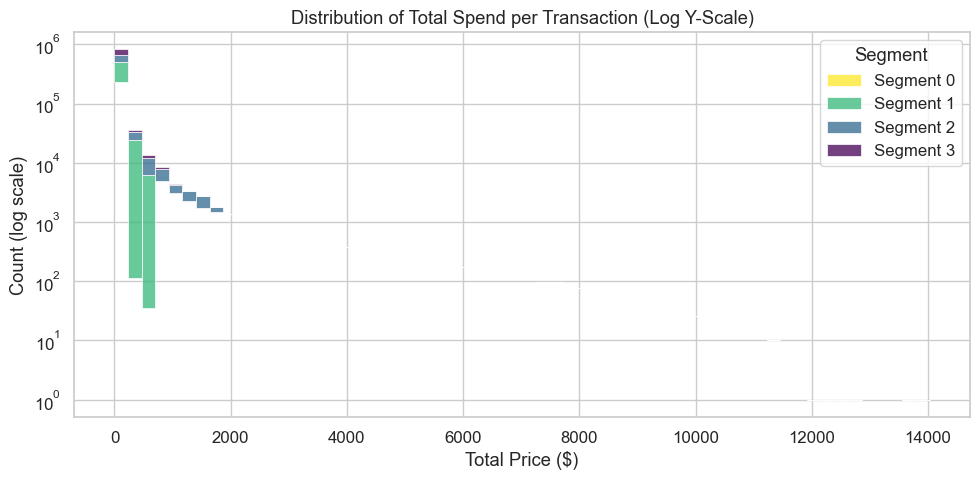

In [16]:
# =============================================================================
# 14. VISUALIZATION SUITE – 7 NEW PLOTS (total 11 with your existing 4)
# =============================================================================
fig_dir = Path('deliverable3_artifacts/figures')
fig_dir.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# 1. Distribution of Total Spend (log-scale) – shows segment separation
# ------------------------------------------------------------------
plt.figure(figsize=(10,5))

# ---- use kde=False + multiple=True to get *real* histograms ----
sns.histplot(
    data=df_sample,
    x='Total_Price',
    hue='sales_cluster',
    palette='viridis',
    log_scale=(False, True),      # X linear, Y log
    bins=60,
    kde=False,
    multiple='stack',            # stack the bars so you see every segment
    alpha=0.75,
    edgecolor='white',
    linewidth=0.5
)

plt.title('Distribution of Total Spend per Transaction (Log Y-Scale)')
plt.xlabel('Total Price ($)')
plt.ylabel('Count (log scale)')
plt.legend(title='Segment', labels=[f'Segment {i}' for i in range(4)])
plt.tight_layout()
plt.savefig(fig_dir/'01_total_spend_dist.png', dpi=300, bbox_inches='tight')
plt.show()

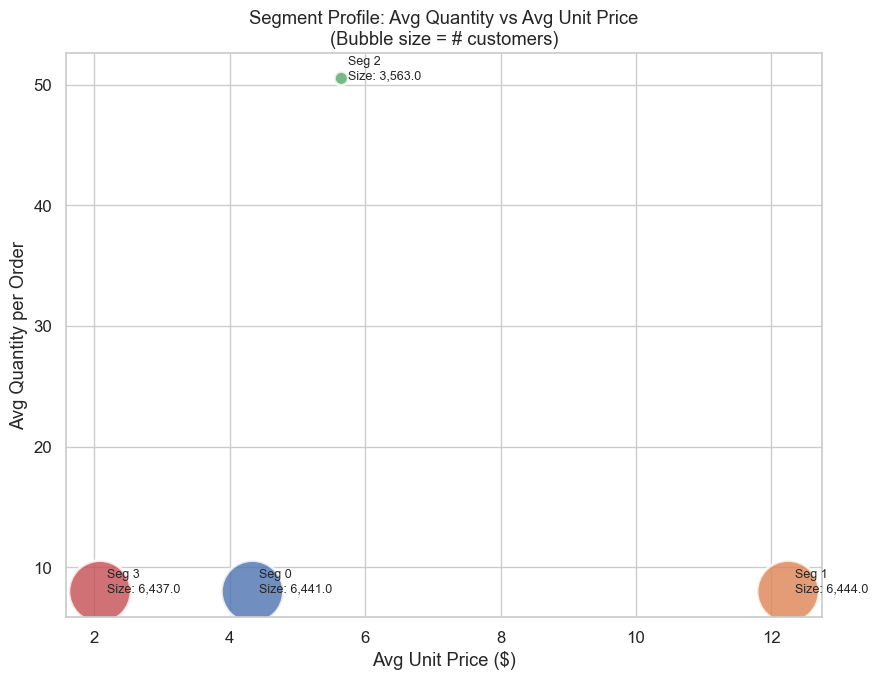

In [17]:
# ------------------------------------------------------------------
# 2. Avg Quantity vs Avg Unit Price (bubble = segment size)
# ------------------------------------------------------------------
seg_summary = df_sample.groupby('sales_cluster').agg(
    avg_qty=('Quantity', 'mean'),
    avg_price=('Unit_Price', 'mean'),
    size=('Customer_ID', 'nunique')
).reset_index()

plt.figure(figsize=(9,7))
sns.scatterplot(data=seg_summary, x='avg_price', y='avg_qty',
                size='size', sizes=(100, 2000), hue='sales_cluster',
                palette='deep', legend=False, alpha=0.8)
for i, row in seg_summary.iterrows():
    plt.text(row['avg_price']+0.1, row['avg_qty'], f"Seg {i}\nSize: {row['size']:,}",
             fontsize=9, ha='left')
plt.title('Segment Profile: Avg Quantity vs Avg Unit Price\n(Bubble size = # customers)')
plt.xlabel('Avg Unit Price ($)')
plt.ylabel('Avg Quantity per Order')
plt.tight_layout()
plt.savefig(fig_dir/'02_segment_profile.png', dpi=300)
plt.show()

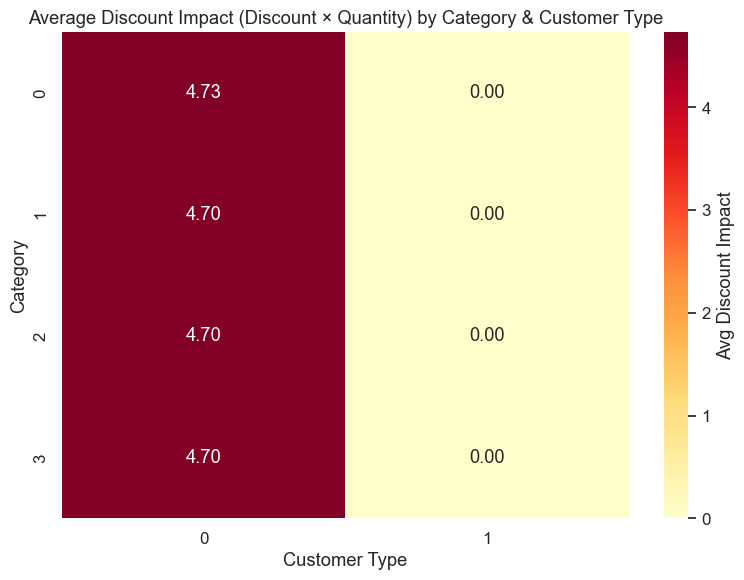

In [18]:
# ------------------------------------------------------------------
# 3. Discount Impact Heatmap (Discount × Quantity)
# ------------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df_sample.pivot_table(values='discount_impact', index='Category',
                                  columns='Customer_Type', aggfunc='mean'),
            annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Avg Discount Impact'})
plt.title('Average Discount Impact (Discount × Quantity) by Category & Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Category')
plt.tight_layout()
plt.savefig(fig_dir/'03_discount_heatmap.png', dpi=300)
plt.show()

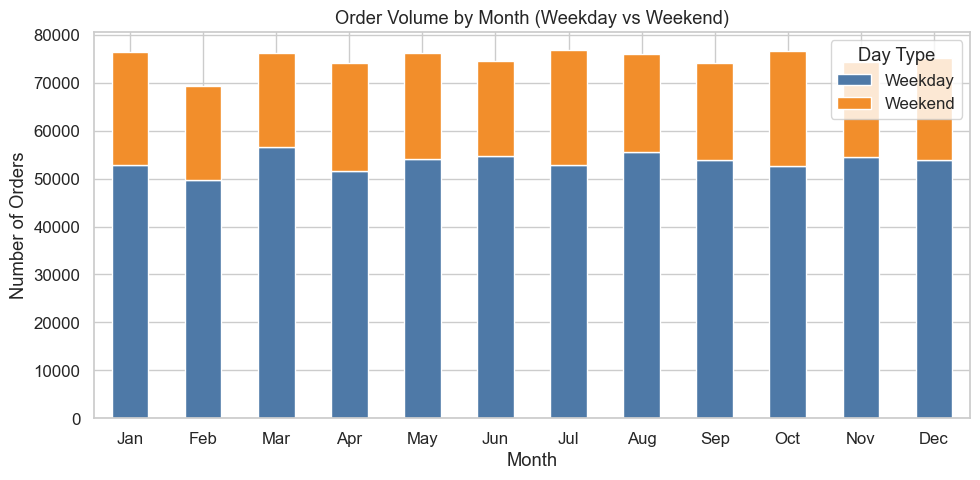

In [19]:
# ------------------------------------------------------------------
# 4. Temporal Patterns – Orders by Month & Weekend
# ------------------------------------------------------------------
temporal = df_sample.groupby(['month', 'is_weekend']).size().unstack(fill_value=0)
temporal.columns = ['Weekday', 'Weekend']
temporal = temporal.reset_index()

plt.figure(figsize=(10,5))
temporal.plot(x='month', kind='bar', stacked=True, color=['#4e79a7', '#f28e2b'],
              ax=plt.gca())
plt.title('Order Volume by Month (Weekday vs Weekend)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun',
                                   'Jul','Aug','Sep','Oct','Nov','Dec'], rotation=0)
plt.legend(title='Day Type')
plt.tight_layout()
plt.savefig(fig_dir/'04_temporal_pattern.png', dpi=300)
plt.show()

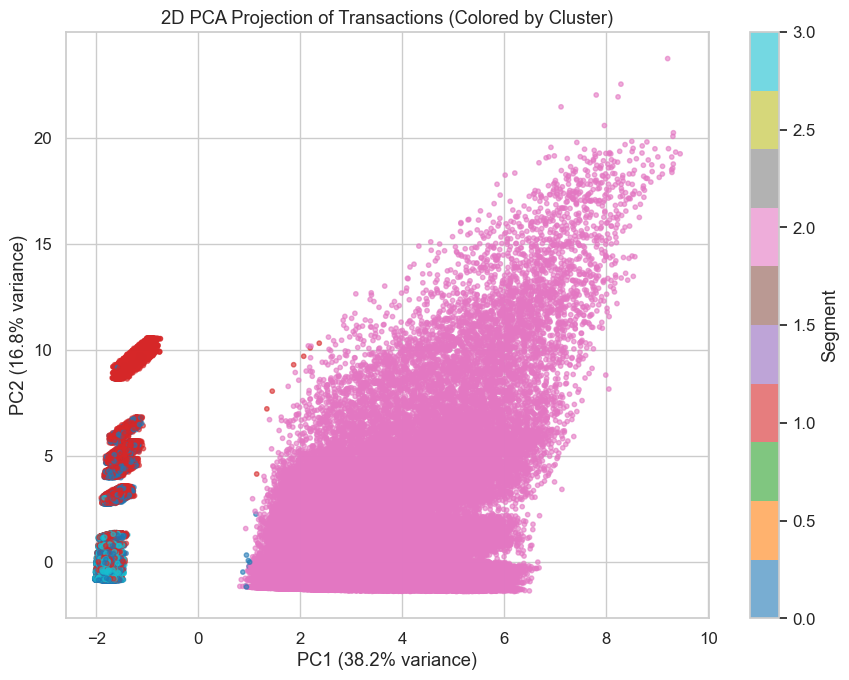

In [20]:
# ------------------------------------------------------------------
# 5. PCA 2D Projection with Clusters
# ------------------------------------------------------------------
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(9,7))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=df_sample['sales_cluster'],
                      cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label='Segment')
plt.title('2D PCA Projection of Transactions (Colored by Cluster)')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
plt.tight_layout()
plt.savefig(fig_dir/'05_pca_2d.png', dpi=300)
plt.show()

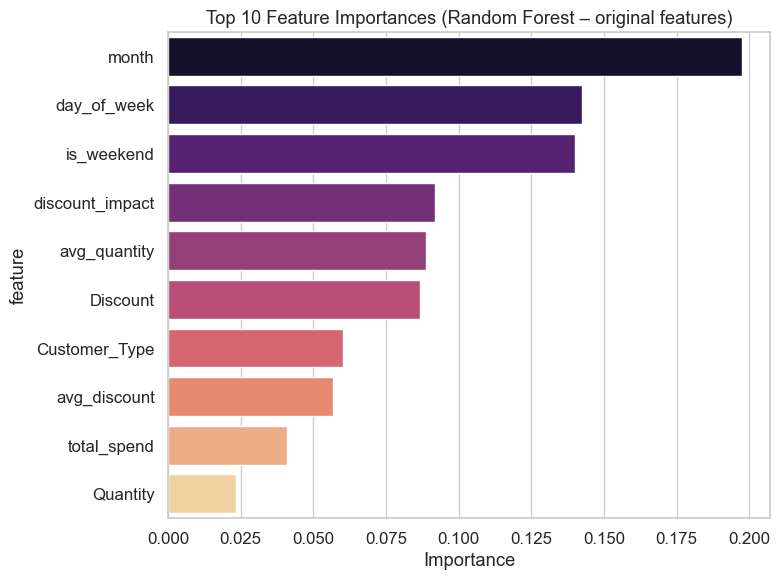

In [21]:
# ------------------------------------------------------------------
# 6. Feature Importance from Random Forest (on original features)
# ------------------------------------------------------------------
# ---- train a quick RF on the *original* X (not PCA) -----------------
rf_interp = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_interp.fit(X, df_sample['sales_cluster'])      # X = original columns

importances = rf_interp.feature_importances_
feat_names  = X.columns

# ---- safety check (should never trigger) -------------------------
assert len(importances) == len(feat_names), "Length mismatch!"

imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(10), x='importance', y='feature', palette='magma')
plt.title('Top 10 Feature Importances (Random Forest – original features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig(fig_dir/'06_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

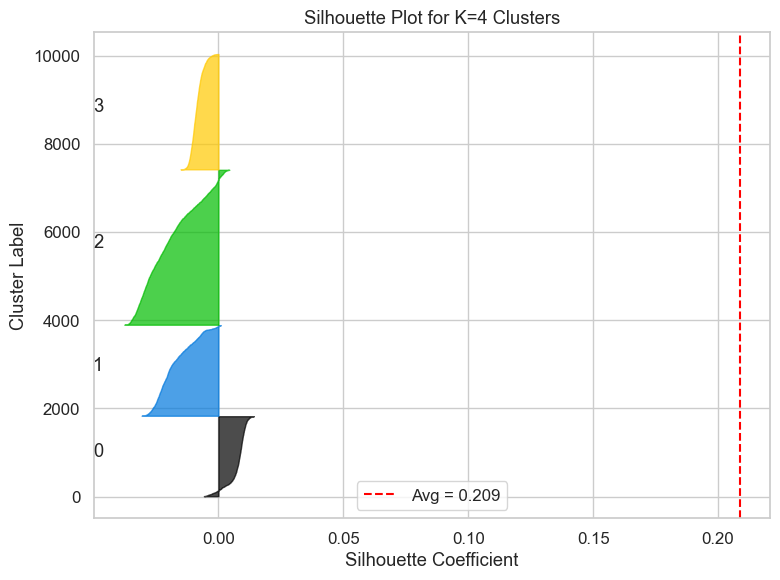

In [22]:
# ------------------------------------------------------------------
# 7. Silhouette Plot (diagnostic)
# ------------------------------------------------------------------
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

sample = X_pca[np.random.choice(X_pca.shape[0], 10000, replace=False)]
labels_sample = df_sample['sales_cluster'].iloc[np.random.choice(df_sample.shape[0], 10000)]

sil_values = silhouette_samples(sample, labels_sample)
y_lower = 10
fig, ax = plt.subplots(figsize=(8,6))

for i in range(4):
    ith_cluster_sil = sil_values[labels_sample == i]
    ith_cluster_sil.sort()
    size_cluster_i = ith_cluster_sil.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 4)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot for K=4 Clusters')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster Label')
ax.axvline(x=sil, color="red", linestyle="--", label=f'Avg = {sil:.3f}')
ax.legend()
plt.tight_layout()
plt.savefig(fig_dir/'07_silhouette_plot.png', dpi=300)
plt.show()